<a href="https://colab.research.google.com/github/eminshall/QuantFinanceWorkbooks/blob/main/Mean_Variance_Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Data Preparation

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
#Grab Data
import yfinance as yf

#Usual Suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [49]:
#Create a Portfolio of tech and gold stocks
symbols = [
    'AAPL',
    'MSFT',
    'META',
    'AMZN',
    'XOM',
    'UNH',
    'JNJ',
    'V',
    'HD',
    'ABBV',
    'KO',
    'DIS',
    'T',
    'UPS',
    'LMT',
    'CAT',
    'F',
    'MAR',
    'O',
    'HSY'
]

In [51]:
#Get the stock data
data = yf.download(symbols, start="2018-01-01", end="2023-02-28")
data.head()

[*********************100%***********************]  20 of 20 completed


Adj Close                                                \
                 AAPL       ABBV       AMZN         CAT         DIS   
Date                                                                  
2018-01-02  40.888069  77.285187  59.450500  138.114670  108.726059   
2018-01-03  40.880939  78.494598  60.209999  138.325729  109.192848   
2018-01-04  41.070831  78.046944  60.479500  140.225479  109.144234   
2018-01-05  41.538445  79.405594  61.457001  142.441788  108.551003   
2018-01-08  41.384163  78.133331  62.343498  146.021255  106.994987   

                                                                      ...  \
                    F          HD         HSY         JNJ         KO  ...   
Date                                                                  ...   
2018-01-02   9.871420  165.890106  100.043510  121.116432  38.548203  ...   
2018-01-03   9.949393  166.754700   99.624123  122.273430  38.463554  ...   
2018-01-04  10.120937  168.078110  100.320152  122.264748  39.005306  ...   
2018-01-05  10.292476  169.833786  100.802040  123.273865  38.996834  ...   
2018-01-08  10.253489  169.427887  101.783638  123.430351  38.937584  ...   

             Volume                                                           \
                LMT      MAR      META      MSFT        O         T      UNH   
Date                                                                           
2018-01-02  1189600  2949200  18151900  22483800  1672872  42626974  3485000   
2018-01-03   893400  1507900  16886600  26061400  1593408  51851150  2417600   
2018-01-04  1443000  3187000  13880900  21912000  1939334  36894187  2749100   
2018-01-05  1241100  3404400  13574500  23407100  1471219  29386048  2432800   
2018-01-08  1084500  3275500  17994700  22113000  1133342  35276524  2850800   

                                        
                UPS        V       XOM  
Date                                    
2018-01-02  5413000  6080900  11469300  
2018-01-03  5655600  6946100  13957700  
2018-01-04  5473100  7805300  10863000  
2018-01-05  3699200  8590500  11047600  
2018-01-08  3243000  6660700  10927100  

[5 rows x 120 columns]

In [52]:
#Visualize cumulative returns of each stock in the portfolio
portfolio_returns = data['Adj Close'].pct_change().dropna()

port_comps_rets_cumprod = portfolio_returns.add(1).cumprod().sub(1)*100

fig = px.line(port_comps_rets_cumprod, x=port_comps_rets_cumprod.index, y=port_comps_rets_cumprod.columns, title='Cumulative Returns of Portfolio Stocks (2010-2020)')

fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Cumulative Return in %')

fig.show()

In [54]:
#Import S&P500 data and plot cum_returns for performance comparison
sp_index = yf.download('^GSPC', start='2018-01-01', end="2023-02-28")
sp_index.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,2683.729980,2695.889893,2682.360107,2695.810059,2695.810059,3397430000
2018-01-03,2697.850098,2714.370117,2697.770020,2713.060059,2713.060059,3544030000
2018-01-04,2719.310059,2729.290039,2719.070068,2723.989990,2723.989990,3697340000
2018-01-05,2731.330078,2743.449951,2727.919922,2743.149902,2743.149902,3239280000
2018-01-08,2742.669922,2748.510010,2737.600098,2747.709961,2747.709961,3246160000


<Axes: >

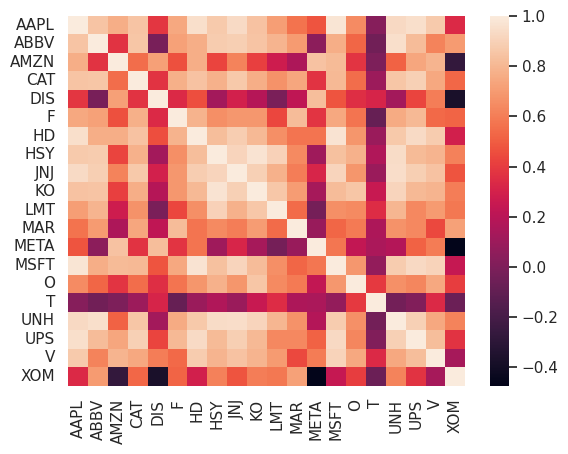

In [55]:
#Create a correlation heatmap to visualize portfolio asset neutrality
port_corr = port_comps_rets_cumprod.corr()

sns.heatmap(port_corr)

# Step 2: Optimization

In [15]:
!pip install PyPortfolioOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 KB 2.5 MB/s eta 0:00:00


In [56]:
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.expected_returns import ema_historical_return
from pypfopt.risk_models import exp_cov
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier
from pypfopt.plotting import plot_weights
from pypfopt.cla import CLA

train = portfolio_returns[:"2021-05-30"]
test = portfolio_returns["2021-05-31":]

mu = expected_returns.ema_historical_return(train, returns_data = True, span = 500)
Sigma = risk_models.exp_cov(train, returns_data = True, span = 180)

In [57]:
mu

AAPL    0.482579
ABBV    0.310709
AMZN    0.325962
CAT     0.631791
DIS     0.348453
F       0.840881
HD      0.362709
HSY     0.290996
JNJ     0.204723
KO      0.168178
LMT     0.132250
MAR     0.337955
META    0.500465
MSFT    0.442765
O       0.219010
T       0.064655
UNH     0.442568
UPS     0.679428
V       0.264695
XOM     0.283278
Name: 2021-05-28 00:00:00, dtype: float64

In [58]:
ret_ef = np.arange(0, 0.840881, 0.01)
vol_ef = []
for i in np.arange(0, 0.840881, 0.01):
    ef = EfficientFrontier(mu, Sigma)
    ef.efficient_return(i)
    vol_ef.append(ef.portfolio_performance()[1])

In [59]:
ef = EfficientFrontier(mu, Sigma)
ef.min_volatility()
min_vol_ret = ef.portfolio_performance()[0]
min_vol_vol = ef.portfolio_performance()[1]

In [60]:
ef = EfficientFrontier(mu, Sigma)
ef.max_sharpe(risk_free_rate=0.009)
max_sharpe_ret = ef.portfolio_performance()[0]
max_sharpe_vol = ef.portfolio_performance()[1]

/usr/local/lib/python3.9/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:444: UserWarning:

The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.



Text(0.5, 1.0, 'Efficient Frontier')

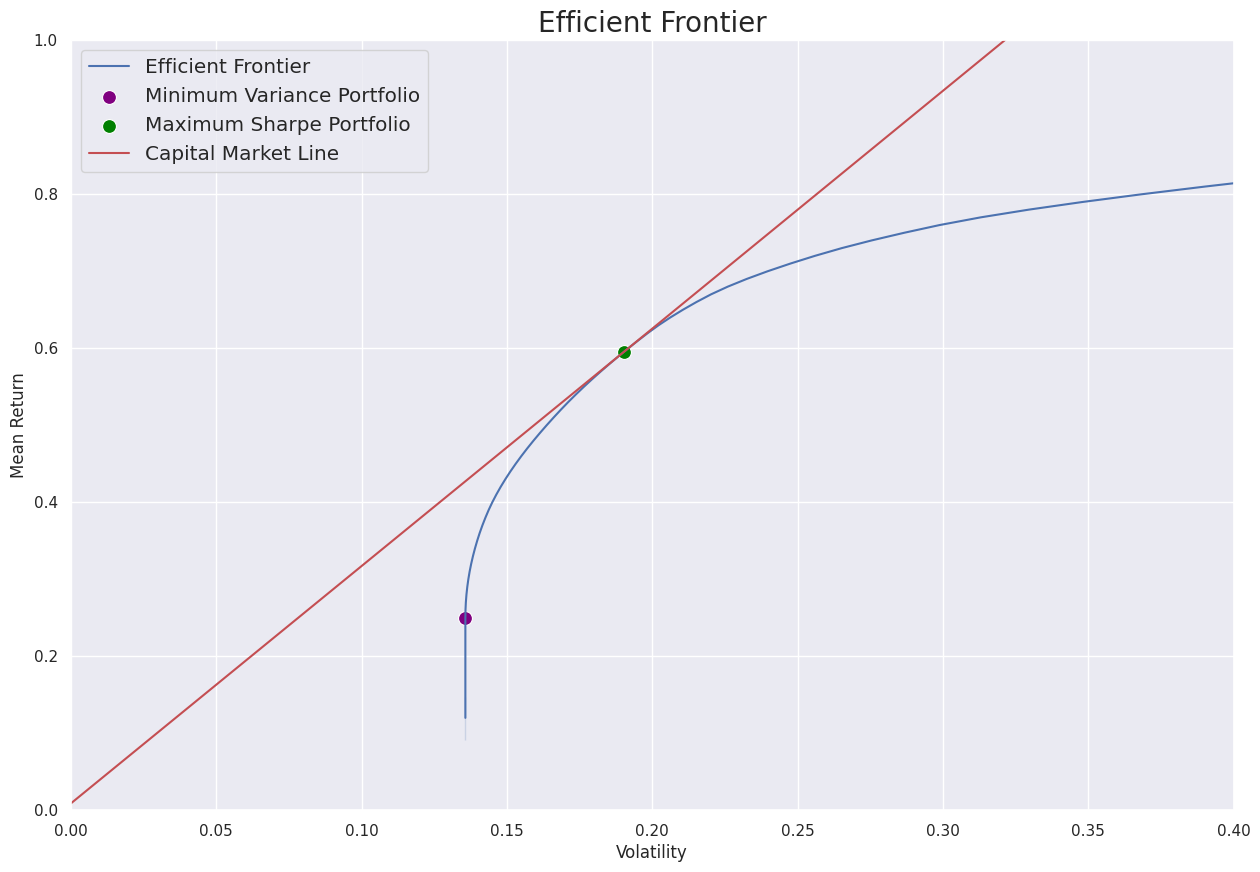

In [61]:
sns.set()

fig, ax = plt.subplots(figsize = [15,10])

sns.lineplot(x = vol_ef, y = ret_ef, label = "Efficient Frontier", ax = ax)
sns.scatterplot(x = [min_vol_vol], y = [min_vol_ret], ax = ax, label = "Minimum Variance Portfolio", color = "purple", s = 100)
sns.scatterplot(x = [max_sharpe_vol], y = [max_sharpe_ret], ax = ax, label = "Maximum Sharpe Portfolio", color = "green", s = 100)
sns.lineplot(x = [0, max_sharpe_vol, 1], y = [0.009, max_sharpe_ret, 3.096], label = "Capital Market Line", ax = ax, color = "r")

ax.set(xlim = [0, 0.4])
ax.set(ylim = [0, 1])
ax.set_xlabel("Volatility")
ax.set_ylabel("Mean Return")
plt.legend(fontsize='large')
plt.title("Efficient Frontier", fontsize = '20')

Expected annual return: 25.0%
Annual volatility: 13.6%
Sharpe Ratio: 1.77


(0.24979291281835447, 0.13569754522131786, 1.7744824523216673)

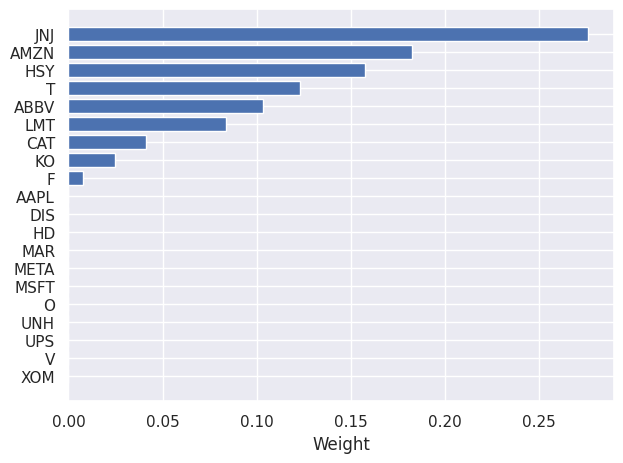

In [62]:
# Minimum Variance
ef = EfficientFrontier(mu, Sigma)
raw_weights_minvar_exp = ef.min_volatility()

plot_weights(raw_weights_minvar_exp)
ef.portfolio_performance(verbose = True, risk_free_rate = 0.009)

Expected annual return: 59.6%
Annual volatility: 19.0%
Sharpe Ratio: 3.08


(0.595675993906882, 0.19035895023078483, 3.0819459405277008)

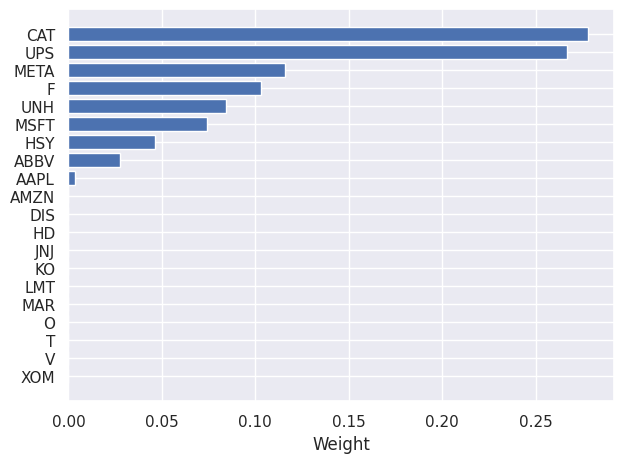

In [63]:
# Maximum Variance
ef = EfficientFrontier(mu, Sigma)
raw_weights_maxsharpe_exp = ef.max_sharpe(risk_free_rate=0.009)

plot_weights(raw_weights_maxsharpe_exp)
ef.portfolio_performance(verbose = True, risk_free_rate = 0.009)

# Step 3: Backtesting

In [64]:
weights_minvar_exp = list(raw_weights_minvar_exp.values())
weights_maxsharpe_exp = list(raw_weights_maxsharpe_exp.values())

ret_1 = test.dot(weights_minvar_exp).add(1).cumprod().subtract(1).multiply(100)
ret_2 = test.dot(weights_maxsharpe_exp).add(1).cumprod().subtract(1).multiply(100)

ind_ret = sp_index["2021-05-31":]['Adj Close'].pct_change().add(1).cumprod().subtract(1).multiply(100)

In [65]:
back = pd.DataFrame({"MinVar":ret_1, "MaxSharpe":ret_2})
back = pd.concat([back, ind_ret],  join = "outer", axis = 1)
back.drop(back.tail(1).index,inplace=True)

back.interpolate(method = "linear", inplace = True)

fig = px.line(back, x = back.index, y = back.columns, title = "Portfolio Performance")
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Cumulative Return in %')

fig.show()